## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
#TODO: this is a bit of a hack, to add /molten_export/ to sys.path, so we can export molten while within the repo
#probably want to do this in a cleaner way before public release
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('Testing_Vignette.ipynb'), '..', '..')))

## Circle Data

Synthetic data contains source 3 drift occuring from index 1000-1250 and affecting 66% of the data points. Data distribution based drift detectors can be applied to 'var1' or 'var 2'. For this example, error rate based detectors will use a Naive Bayes classifier. 

In [3]:
df = pd.read_csv(r'S:\User Workspace\lnicholl\molten\data\ArtificialDataSets--Other\ArtificialDataSets_20210702\ArtificialDataSets\circleG\dataCircleGSev3Sp3Train.csv', usecols = [0,1,2],names = ['var1','var2','y'])

## Univariate Drift Detectors

#### Page Hinkley

In [4]:
from molten.other.PageHinkley import PageHinkley

In [5]:
#setup one-directional PH test

delta = 0.01
xi = 15
ph = PageHinkley(delta=delta, xi=xi, direction='negative', burn_in = 30)

# setup DF to record results
status = pd.DataFrame(columns=['index', 'actual value', 'drift?'])

# iterate through data and run PH
for i in range(len(df)):
    obs = df['var2'][i]
    ph.update(next_obs=obs, obs_id=i)
    status.loc[i] = [i, obs, ph.drift_state]

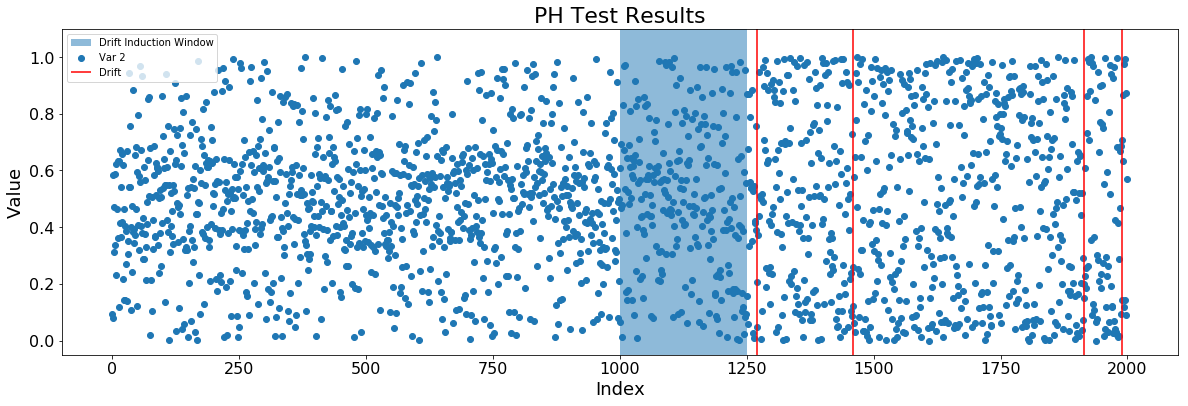

In [6]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'actual value', data=status)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('PH Test Results', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5)

for t in status.loc[status['drift?'] == 'drift']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red')
   
plt.legend(['Drift Induction Window', 'Var 2', 'Drift'])
plt.show()

#### CUSUM

In [10]:
from molten.other.cusum import CUSUM

In [11]:
#mean / std of 'Var 2' pre-drift 
mean = np.mean(df.iloc[0:1000,1])
std = np.std(df.iloc[0:1000,1])
cusum = CUSUM(target=mean,sd_hat=std, burn_in=50,delta=0.005, threshold=40, direction=None)

# setup DF to record results
status = pd.DataFrame(columns=['index', 'actual value', 'drift?'])

# iterate through data and run PH
for i in range(len(df)):
    obs = df['var2'][i]
    cusum.update(obs)
    status.loc[i] = [i, obs, cusum.drift_state]

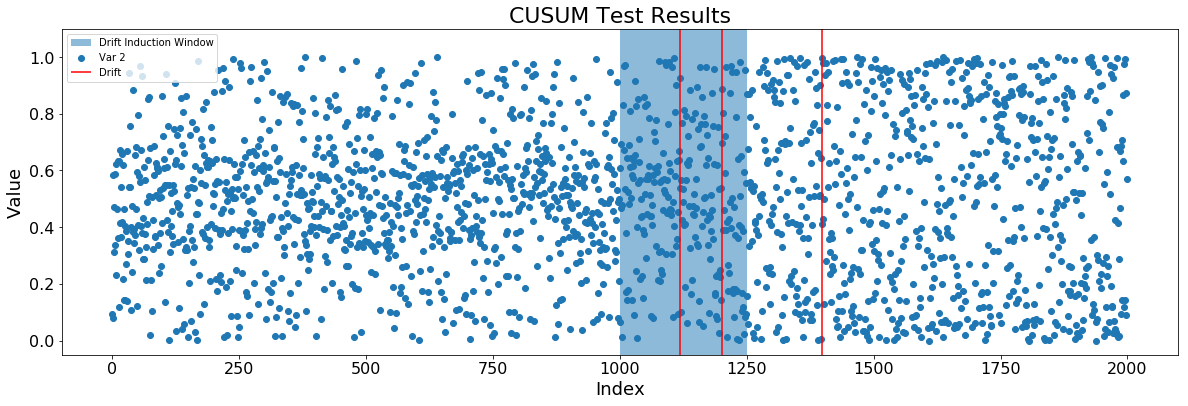

In [12]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'actual value', data=status)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('CUSUM Test Results', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5)

for t in status.loc[status['drift?'] == 'drift']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red')

plt.legend(['Drift Induction Window','Var 2','Drift'])
plt.show()

## Data-Distribution Drift Detection 

#### PCA-CD

In [4]:
from molten.distribution.PCA_CD import PCA_CD
from sklearn.preprocessing import StandardScaler

In [5]:
#init PCA_CD
pca_cd = PCA_CD(window_size = 350, delta = 0.05, verbose = False)

# setup DF to record results
status = pd.DataFrame(columns=['index', 'var1', 'var2', 'drift?'])

# iterate through X data and run PCA
data = df[['var1','var2']]
data = pd.DataFrame(StandardScaler().fit_transform(data))
for i in range(len(df)):
    pca_cd.update(data.iloc[[i]])
    status.loc[i] = [i, data.iloc[i,0], data.iloc[i,1], pca_cd.drift_state]

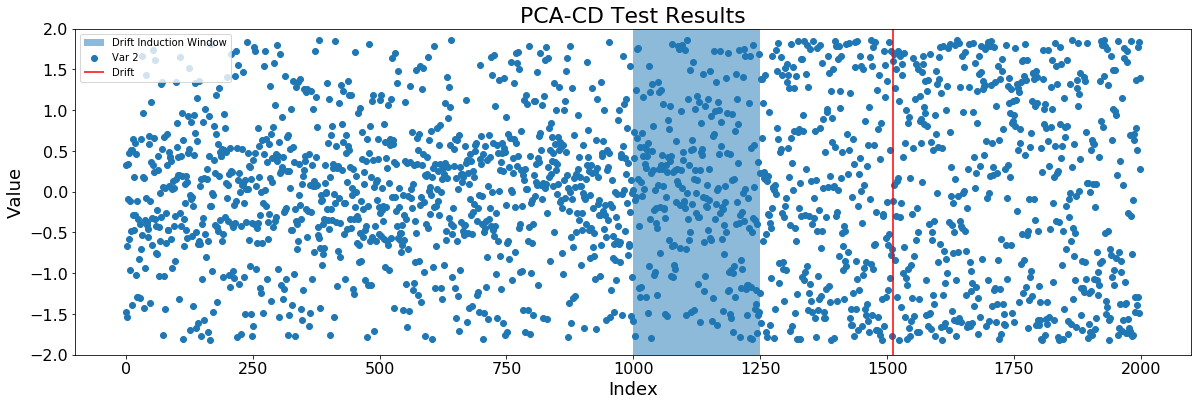

In [6]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'var2', data=status)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('PCA-CD Test Results', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-2,2])

plt.axvspan(1000, 1250, alpha=0.5)

for t in status.loc[status['drift?'] == 'drift']['index']:
    plt.vlines(x=t, ymin=-2, ymax=2, colors='red')
   
plt.legend(['Drift Induction Window','Var 2','Drift'])
plt.show()

#### KDQ Tree

In [13]:
from molten.distribution.kdqTreeDetector import kdqTreeDetector

ModuleNotFoundError: No module named 'plotly'

In [ ]:
np.random.seed(123)

#init KDQ-Tree
min_points_in_bin = 100
window_size = 300
num_bootstrap_samples = 500
gamma = 0.6
alpha = 0.2
verbose = False

kdq = kdqDriftDetector(window_size = window_size, 
    min_points_in_bin=min_points_in_bin,
     num_bootstrap_samples=num_bootstrap_samples,
    gamma=gamma, alpha=alpha, verbose = verbose)

# setup DF to record results
status = pd.DataFrame(columns=['index', 'var1', 'var2', 'drift?'])

# iterate through X data and run KDQ tree
data = df[['var1','var2']]
for i in range(len(data)):
    kdq.update(data.iloc[[i]])
    status.loc[i] = [i, data.iloc[i, 0], data.iloc[i, 1], kdq.drift_state]

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'var2', data=status)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('KDQ Tree Test Results', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5)

for t in status.loc[status['drift?'] == 'drift']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red')
   
plt.legend(['Drift Induction Window','Var 2','Drift'])
plt.show()

### Error-rate based detectors

Naive Bayes Classifier train on first 500 rows of data. Apply learning in an online mannner. Retraining recs have +500 added to account for starting index of test data

#### Linear Four Rates

In [7]:
from molten.performance.lfr import LinearFourRates

In [8]:
# setup classifier: train on first 500 rows
X_train = df.iloc[0:500, 0:2]
y_train = df.iloc[0:500, 2]
clf = GaussianNB().fit(X_train, y_train)

#setup LFR
nrows = 300
decay = 0.6
mc = 5000
burn_in = 10
subsample = 10
warning = 0.01
detect = 0.001
lfr = LinearFourRates(time_decay_factor=decay,warning_level=warning, detect_level=detect, num_mc=mc, burn_in=burn_in,subsample=subsample)

#setup DF to store results
status = pd.DataFrame(columns=['index', 'y', 'y_pred', 'drift?','accuracy'])
correct = 0 

#run LFR and retrain
n = 1
for i in range(500, len(df)):
    np.random.seed(123)

    X_test = df.iloc[[i], 0:2]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.iloc[[i], 2])
    
    #increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    lfr.update(y_pred, y_true)
    status.loc[i] = [i, y_true, y_pred, lfr.drift_state, accuracy]

    # if drift, retrain. If not wanting to retrain, omit following block
    if lfr.drift_state == 'drift':

        retrain_start = lfr.retraining_recs[0] + 500 
        retrain_end = lfr.retraining_recs[1] + 500
        if retrain_start == retrain_end: #minimum retraining window for case of sudden drift
            retrain_start = max(0,retrain_start - 300)
        X_train = df.iloc[retrain_start:retrain_end,0:2]
        y_train = df.iloc[retrain_start:retrain_end, 2]
        clf = GaussianNB().fit(X_train,y_train)
        print("Retrain Window: ", retrain_start, "-", retrain_end)
        
    n += 1

Retrain Window:  749 - 1049
Retrain Window:  1049 - 1349
Retrain Window:  1579 - 1819


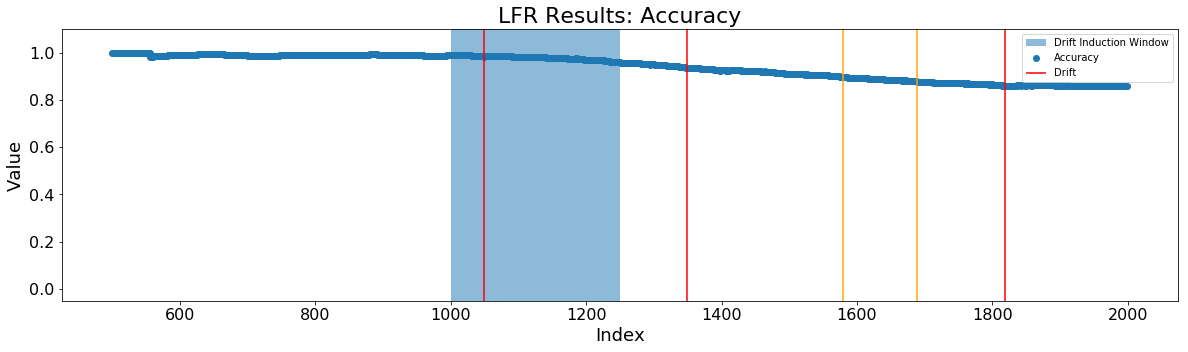

In [9]:
plt.figure(figsize=(20, 5))
plt.scatter('index', 'accuracy', data=status)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('LFR Results: Accuracy', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5)

for t in status.loc[status['drift?'] == 'drift']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red')
    
for t in status.loc[status['drift?'] == 'warning']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='orange')
 
plt.legend(['Drift Induction Window','Accuracy','Drift'])
plt.show()

#### ADWIN

In [10]:
from molten.performance.ADWIN import ADWIN

In [11]:
np.random.seed(123)
# setup classifier: train on first 500 rows
X_train = df.iloc[0:500, 0:2]
y_train = df.iloc[0:500, 2]
clf = GaussianNB().fit(X_train, y_train)


#setup ADWIN
adwin = ADWIN()

# setup DF to record results
status = pd.DataFrame(columns=['index', 'results', 'accuracy', 'adwin mean',  'drift?'])
correct = 0

# run ADWIN
n = 1
for i in range(500, len(df)):

    X_test = df.iloc[[i], 0:2]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.iloc[[i], 2])

    # increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    adwin.update(int(y_true == y_pred))
    status.loc[i] = [i, int(y_true==y_pred), accuracy, adwin.mean(), adwin.drift_state]

    # if drift, retrain. If not wanting to retrain, omit following block
    if adwin.drift_state == 'drift':
        retrain_start = adwin.retraining_recs[0] + 500
        retrain_end = adwin.retraining_recs[1] + 500
        X_train = df.iloc[retrain_start:retrain_end, 0:2]
        y_train = df.iloc[retrain_start:retrain_end, 2]
        clf = GaussianNB().fit(X_train, y_train)
        print("Retrain Window: ", retrain_start, "-", retrain_end)

    n += 1

Retrain Window:  628 - 1267
Retrain Window:  756 - 1299
Retrain Window:  884 - 1331
Retrain Window:  948 - 1363
Retrain Window:  1012 - 1491


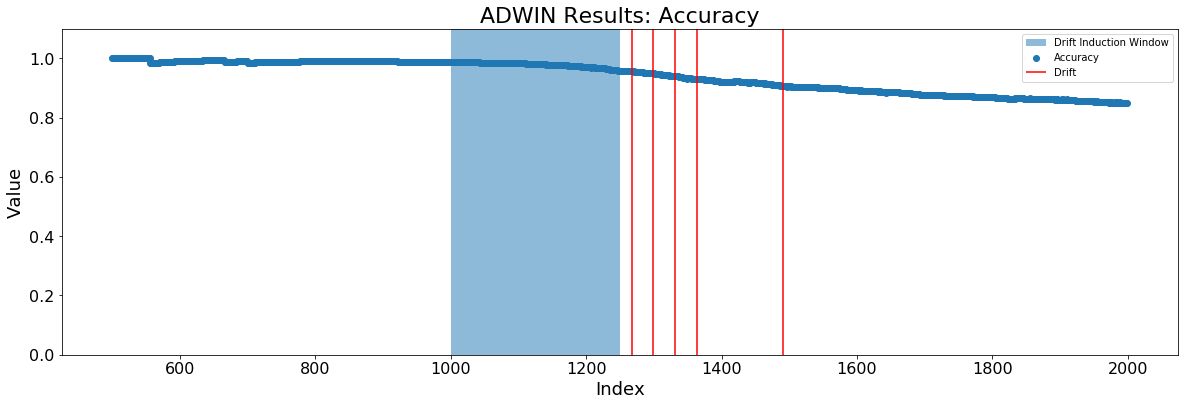

In [12]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'accuracy', data=status)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('ADWIN Results: Accuracy', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([0,1.1])

plt.axvspan(1000, 1250, alpha=0.5)
#plt.vlines(x=status1.loc[retrain_end, 'index'], ymin=0, ymax=1.1, colors='green', linewidth = 7)

for t in status.loc[status['drift?'] == 'drift']['index']:
    plt.vlines(x=t, ymin=0, ymax=1.1, colors='red')
    
plt.legend(['Drift Induction Window','Accuracy','Drift'])   
plt.show()

#### STEPD

In [13]:
from molten.performance.STEPD import STEPD

In [14]:
np.random.seed(123)
# setup classifier: train on first 500 rows
# X_train = df.iloc[0:500, 0:2]
# y_train = df.iloc[0:500, 2]
# X_test = df.iloc[500:1000, 0:2]
# y_train = df.iloc[500:1000, 2]
# df_train = df.iloc[0:500]
# df_test = df.iloc[500:1000]
# df_ex = df.iloc[0:1000]
df_ex = df
# clf = GaussianNB().fit(X_train, y_train)\
train_ix = [0, 500]

clf = GaussianNB().fit(df_ex.iloc[train_ix[0]:train_ix[1], 0:2], df_ex.iloc[train_ix[0]:train_ix[1], 2])

In [15]:
#note that this example is outside STEPD's intended use case
#its best performance would be with an online classifier, that retrain incrementally, with a single sample

# setup STEPD
window_size=30
alpha_warning=.05
alpha_drift=.009
stepd = STEPD(window_size = window_size, alpha_warning = alpha_warning, alpha_drift = alpha_drift)

# setup DF to store results
status = pd.DataFrame(columns=['index', 'y', 'y_pred', 'drift?', 'accuracy'])
correct = 0
n = 1

for i, row in df_ex.iloc[500:].iterrows():
    y_pred = clf.predict(np.array(row[0:2]).reshape(1, -1))
    y_true = row[2]
    
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n
    
    stepd.update(y_pred, y_true)
    status.loc[i] = [i, y_true, y_pred, stepd.drift_state, accuracy]
    if stepd.drift_state == 'drift':
        #retrain the classifier using STEPD's recommendations
        train_ix = stepd.retraining_recs
    else:
        #update the classifier with the newest sample
        train_ix[1] = train_ix[1] + 1
    clf = GaussianNB().fit(df_ex.iloc[train_ix[0]:train_ix[1], 0:2], df_ex.iloc[train_ix[0]:train_ix[1], 2])
    
    n += 1

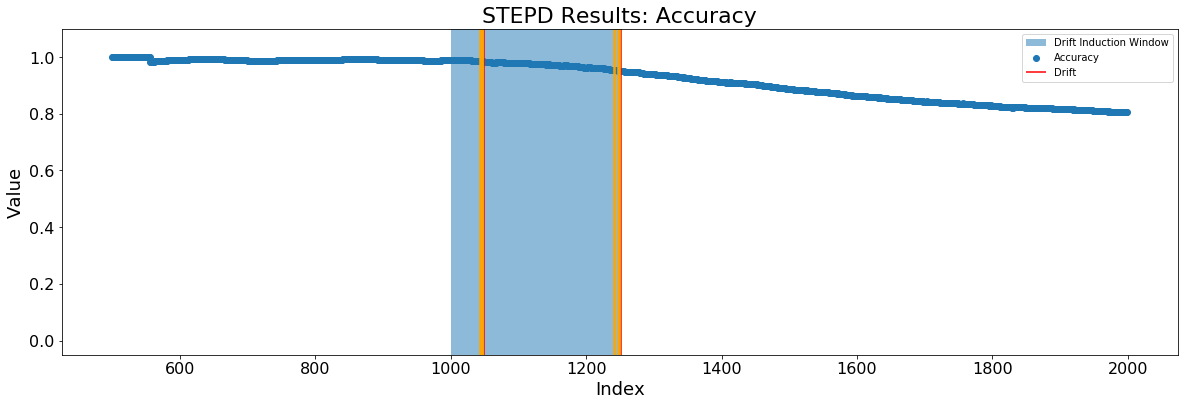

In [16]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'accuracy', data=status)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('STEPD Results: Accuracy', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5)

for t in status.loc[status['drift?'] == 'drift']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red')
    
for t in status.loc[status['drift?'] == 'warning']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='orange')
 
plt.legend(['Drift Induction Window','Accuracy','Drift'])
plt.show()

#### EDDM

In [17]:
from molten.performance.EDDM import EDDM

In [18]:
np.random.seed(123)
# setup classifier: train on first 500 rows
X_train = df.iloc[0:500, 0:2]
y_train = df.iloc[0:500, 2]
clf = GaussianNB().fit(X_train, y_train)

# setup STEPD
eddm = EDDM()

# setup DF to store results
status = pd.DataFrame(columns=['index', 'y', 'y_pred', 'drift?', 'accuracy'])
correct = 0

# run EDDM and retrain
n = 1
for i in range(500, len(df)):

    X_test = df.iloc[[i], 0:2]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.iloc[[i], 2])

    # increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    eddm.update(y_pred, y_true)
    status.loc[i] = [i, y_true, y_pred, eddm.drift_state, accuracy]

    # if drift, retrain. If not wanting to retrain, omit following block
    if eddm.drift_state == 'drift':
        retrain_start = eddm.retraining_recs[0] + 500
        retrain_end = eddm.retraining_recs[1] + 500
        if retrain_start == retrain_end: #minimum retraining window for case of sudden drift 
            retrain_start = max(0,retrain_start-300)
        X_train = df.iloc[retrain_start:retrain_end, 0:2]
        y_train = df.iloc[retrain_start:retrain_end, 2]
        clf = GaussianNB().fit(X_train, y_train)
        print("Retrain Window: ", retrain_start, "-", retrain_end)

    n += 1

Retrain Window:  1247 - 1257
Retrain Window:  1042 - 1342
Retrain Window:  1179 - 1479
Retrain Window:  1337 - 1637
Retrain Window:  1549 - 1849


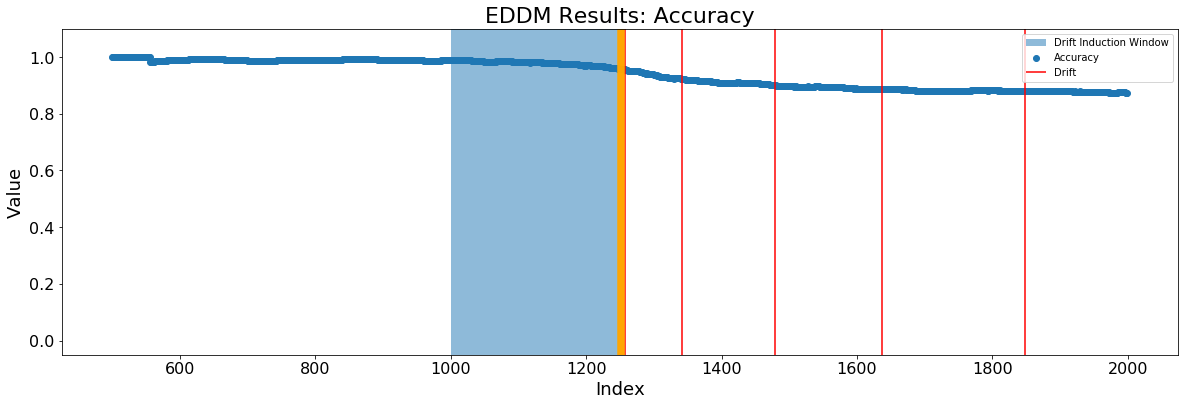

In [19]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'accuracy', data=status)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('EDDM Results: Accuracy', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5)

for t in status.loc[status['drift?'] == 'drift']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red')
    
for t in status.loc[status['drift?'] == 'warning']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='orange')
 
plt.legend(['Drift Induction Window','Accuracy','Drift'])
plt.show()

#### DDM

In [20]:
from molten.performance.DDM import DDM

In [21]:
np.random.seed(123)
# setup classifier: train on first 500 rows
X_train = df.iloc[0:500, 0:2]
y_train = df.iloc[0:500, 2]
clf = GaussianNB().fit(X_train, y_train)

# setup DDM
n_threshold = 100
warning_scale = 7
drift_scale = 10
ddm = DDM(n_threshold = n_threshold, warning_scale = warning_scale, drift_scale = drift_scale)

# setup DF to store results
status = pd.DataFrame(columns=['index', 'y', 'y_pred', 'drift?', 'accuracy'])
correct = 0

# run EDDM and retrain
n = 1
for i in range(500, len(df)):

    X_test = df.iloc[[i], 0:2]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.iloc[[i], 2])

    # increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    ddm.update(y_pred, y_true)
    status.loc[i] = [i, y_true, y_pred, ddm.drift_state, accuracy]

    # if drift, retrain. If not wanting to retrain, omit following block
    if ddm.drift_state == 'drift':
        retrain_start = ddm.retraining_recs[0] + 500
        retrain_end = ddm.retraining_recs[1] + 500
        if retrain_start == retrain_end: #minimum retraining window for case of sudden drift 
            retrain_start = max(0,retrain_start-300)
        X_train = df.iloc[retrain_start:retrain_end, 0:2]
        y_train = df.iloc[retrain_start:retrain_end, 2]
        clf = GaussianNB().fit(X_train, y_train)
        print("Retrain Window: ", retrain_start, "-", retrain_end)

    n += 1

Retrain Window:  1125 - 1201


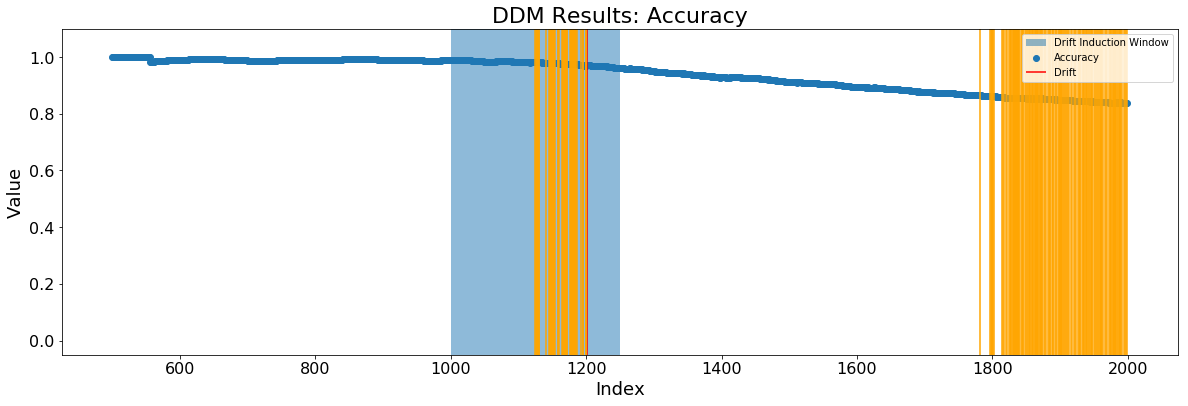

In [22]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'accuracy', data=status)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('DDM Results: Accuracy', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5)

for t in status.loc[status['drift?'] == 'drift']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red')
    
for t in status.loc[status['drift?'] == 'warning']['index']:
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='orange')
 
plt.legend(['Drift Induction Window','Accuracy','Drift'])
plt.show()